# ADaptive LInear NEuron (ADALINE) using pytorch ingredients

My implementation of ADALINE using basic building blocks of pytorch.  A test of what I've learned so far.

In [137]:
import numpy as np
import matplotlib.pyplot as pyp
import matplotlib
import pandas as pd

from copy import deepcopy

%matplotlib inline

In [8]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader

In [138]:
class AdalineSGD_pytorch:
    """
    ADAptive LInear NEuron classifier, using basic
    pytorch ingredients.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
        torch.manual_seed(self.random_state)
        
        self.model = None
        
        self.w_s = []
        self.b_s = []
        self.losses_ = []
        
    # Code taken from Sebastian's repository up to here.
    
    """
    def _lossgrad_w_j(self, weights, bias, targets, X, j):
        
        # The inner * here is element-wise multiplication.
        return ((targets-X.dot(weights)-bias) * X[:,j]).sum() * self.eta*2/X.shape[0]
    
    def _lossgrad_b(self, weights, bias, targets, X):
        return ((targets-X.dot(weights)-bias)).sum() * self.eta*2/X.shape[0]
    
    def _loss(self, X, Y, weights, bias):
        return np.power(Y - X.dot(weights) - bias, 2).sum()/X.shape[0]
    """
    
    def train(self, dataset):
        """
        Takes a pytorch dataloader instance,
        which should deliver the entire training
        dataset when delivering a "batch".  This
        is just slapdash to learn - and ADLINE (can)
        do full-batch training.  I'm also comparing
        to my own numpy version in another notebook
        which implements full-batch learning.
        
        """
        
        X, y = dataset.tensors
        
        J = X.shape[1] # Input dimension.
        model = nn.Linear(J, 1)
        self.model = model
        optimizer = torch.optim.SGD(self.model.parameters(),
                                    lr=self.eta)
        loss_fn = nn.MSELoss(reduction='mean')
        
        for e in range(self.n_iter):
            
            # Predict, loss.
            pred = model(X)[:,0]
            loss = loss_fn(pred, y)
            # Calculate gradient for each parameter.
            loss.backward()
            # Update parameters using gradients.
            optimizer.step()
            # Reset gradients to zero.
            optimizer.zero_grad()   

            self.losses_.append(loss.item())

            self.w_s.append(deepcopy(model.weight.detach().numpy()))
            self.b_s.append(deepcopy(model.bias.detach().numpy()))
            
        self.w_ = model.weight
        self.b_ = model.bias
            
    def predict(self, X):
        """Return class label."""
        return np.where(self.model(X).detach().numpy()[:, 0] >= 0.5, 1, 0)

## Data

In [5]:
import os
import pandas as pd

s = '../data/iris.data'
print('From local Iris path:', s)
df = pd.read_csv(s,
                 header=None,
                 encoding='utf-8')
    
df.tail()

From local Iris path: ../data/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


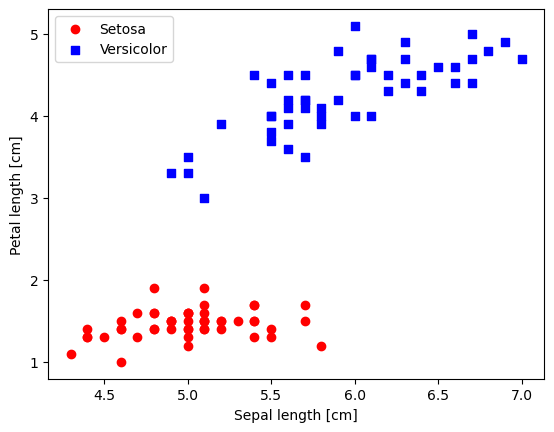

In [6]:
# Plot iris data

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
pyp.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='Setosa')
pyp.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='s', label='Versicolor')

pyp.xlabel('Sepal length [cm]')
pyp.ylabel('Petal length [cm]')
pyp.legend(loc='upper left')

# pyp.savefig('images/02_06.png', dpi=300)
pyp.show()

In [88]:
from matplotlib.colors import ListedColormap

def plot_decision_regions_pytorch(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    X_ = X.numpy()
    x1_min, x1_max = X_[:, 0].min() - 1, X_[:, 0].max() + 1
    x2_min, x2_max = X_[:, 1].min() - 1, X_[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    mesh_X_tensor = torch.from_numpy(np.array([xx1.ravel(),
                                               xx2.ravel()]).T).float()
    lab = classifier.predict(mesh_X_tensor)
    lab = lab.reshape(xx1.shape)
    pyp.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    pyp.xlim(xx1.min(), xx1.max())
    pyp.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        pyp.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

In [53]:
# Make dataset for Pytorch.

X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(y).float()

DS_train = TensorDataset(X_train, y_train)

## Train ADALINE

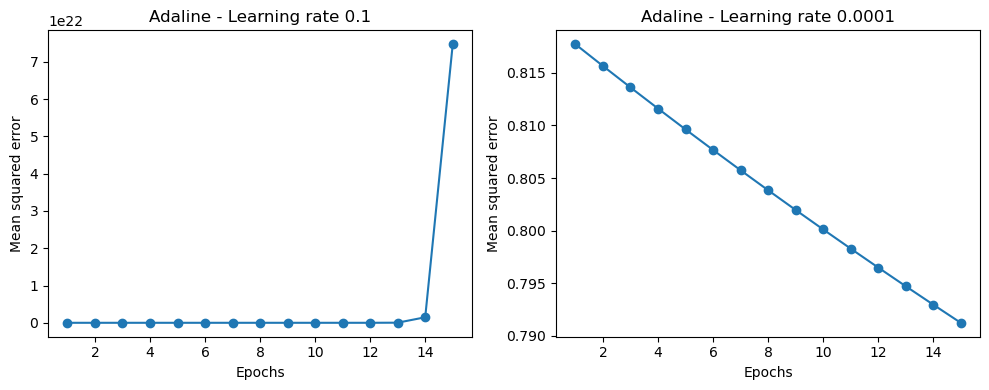

In [128]:
fig, ax = pyp.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineSGD_pytorch(n_iter=15, eta=0.1)
ada1.train(DS_train)
ax[0].plot(range(1, len(ada1.losses_) + 1), ada1.losses_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean squared error')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineSGD_pytorch(n_iter=15, eta=0.0001)
ada2.train(DS_train)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

fig.tight_layout()

In [129]:
# Standardize features.

X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# Make dataset for Pytorch.

X_std_train = torch.from_numpy(X_std).float()
y_train = torch.from_numpy(y).float()

DS_std_train = TensorDataset(X_std_train, y_train)

In [130]:
%matplotlib inline

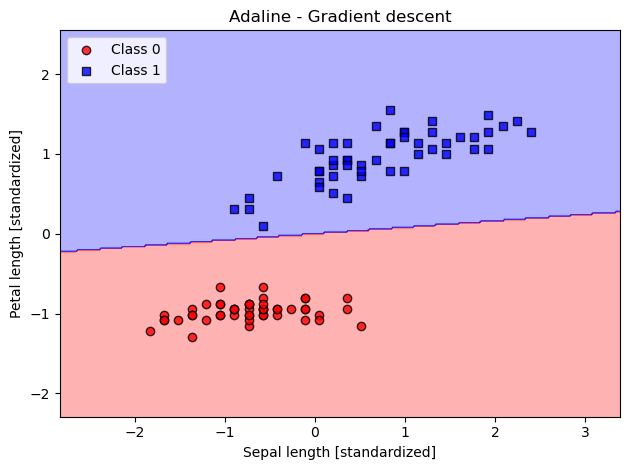

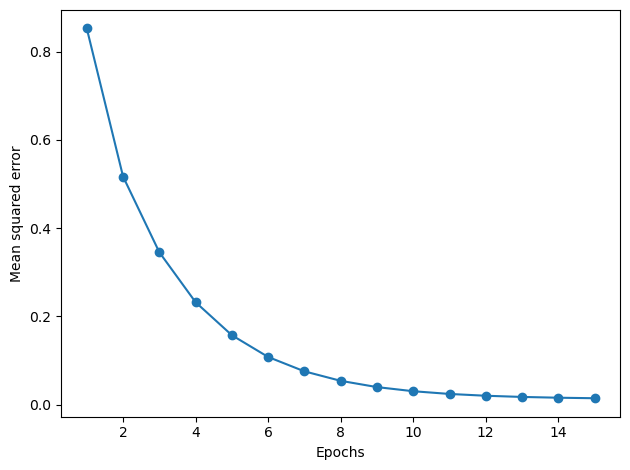

In [139]:
ada_gd = AdalineSGD_pytorch(n_iter=15, eta=0.5, random_state=7)
ada_gd.train(DS_std_train)

plot_decision_regions_pytorch(X_std_train, y, classifier=ada_gd)
pyp.title('Adaline - Gradient descent')
pyp.xlabel('Sepal length [standardized]')
pyp.ylabel('Petal length [standardized]')
pyp.legend(loc='upper left')
pyp.tight_layout()
pyp.show()

pyp.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
pyp.xlabel('Epochs')
pyp.ylabel('Mean squared error')

pyp.tight_layout()
#pyp.savefig('images/02_14_2.png', dpi=300)
pyp.show()

In [140]:
from matplotlib.animation import FuncAnimation, PillowWriter 
%matplotlib notebook

<IPython.core.display.Javascript object>


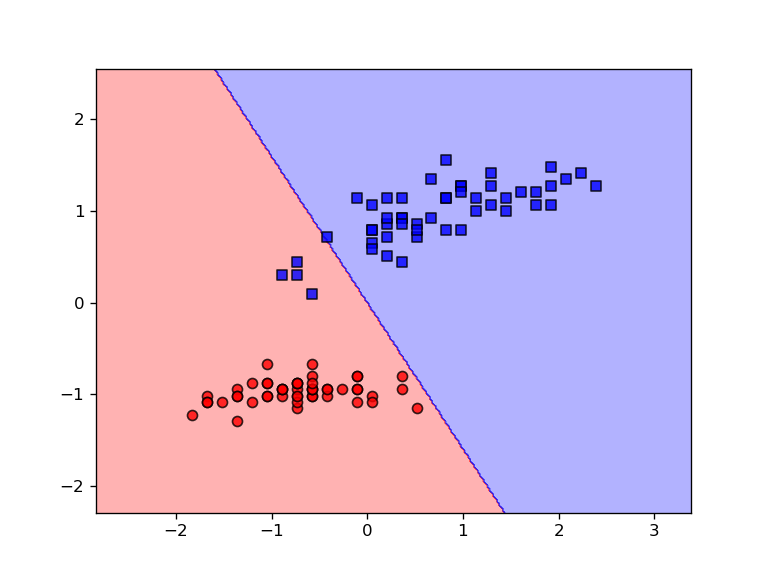

(-2.291886060781545, 2.5481139392184593)

In [149]:
fig, ax = pyp.subplots() 

resolution = 0.02

markers = ('o', 's', '^', 'v', '<')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y))])

X_ = DS_std_train.tensors[0].numpy()
x1_min, x1_max = X_[:, 0].min() - 1, X_[:, 0].max() + 1
x2_min, x2_max = X_[:, 1].min() - 1, X_[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                       np.arange(x2_min, x2_max, resolution))

x1_min, x1_max = X_std[:, 0].min() - 1, X_std[:, 0].max() + 1
x2_min, x2_max = X_std[:, 1].min() - 1, X_std[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                       np.arange(x2_min, x2_max, resolution))

n_iter = 30
ada_gd = AdalineSGD_pytorch(n_iter=n_iter, eta=0.5, random_state=7)
ada_gd.train(DS_std_train)
labs = []
for w_, b_ in zip(ada_gd.w_s, ada_gd.b_s):
        w_ = w_.T
        b_ = b_.item()
    
        lab = np.where(np.array([xx1.ravel(), xx2.ravel()]).T.dot(w_) + b_ >= 0.5, 1, 0)
        lab = lab.reshape(xx1.shape)
        labs.append(lab)

# plot class examples
for idx, cl in enumerate(np.unique(y)):
    pyp.scatter(x=X_std[y == cl, 0], 
                y=X_std[y == cl, 1],
                alpha=0.8, 
                c=colors[idx],
                marker=markers[idx], 
                label=f'Class {cl}', 
                edgecolor='black',
                zorder=1)
    
cnt = [pyp.contourf(xx1, xx2, labs[0], alpha=0.3, cmap=cmap, zorder=0) ]
pyp.xlim(xx1.min(), xx1.max())
pyp.ylim(xx2.min(), xx2.max())

In [146]:
def init():
    pass
    
def update(i):
    
    for tcnt in cnt[0].collections:
        tcnt.remove()
        
    cnt[0] = pyp.contourf(xx1, xx2, labs[i], alpha=0.3, cmap=cmap, zorder=0)
    
    pyp.xlim(xx1.min(), xx1.max())
    pyp.ylim(xx2.min(), xx2.max())



In [147]:
ani = FuncAnimation(fig, update, range(1,n_iter), init_func=init)

In [148]:
pyp.show()